## Johnson Noise Data Analysis

In [351]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, interpolate, integrate, optimize
import sklearn as sk
from scipy.optimize import curve_fit

def uncertainty(data_array):
    # returns uncertainty defined as max value - min value divided by 2
    return (np.max(data_array) - np.min(data_array))/2
    
def uncertainty_mean(data_array):
    # returns uncertainty in the mean: max value - min value, divided by 2 sqrt(N)
    return (np.max(data_array) - np.min(data_array))/2/np.sqrt(len(data_array))

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

### V measured to Johnson Noise

In [27]:
def V_johnson(v_meter, G2):
    # returns johnson noise value given measured voltage and gain settings on HLE
    G1 = 600
    return v_meter*10/G1**2/G2**2

### Amplifier Noise Correction

In [28]:
def amp_noise(resistance_array, initial_v_measured_array):
    # takes as input initial voltage measurements which includes both J and N 
    # contributions for all resistors. Then use an extrapolation scheme to get the R = 0 limit
    # which returns the amplifier noise
    
    interp_func = interpolate.interp1d(resistance_array, initial_v_measured_array, fill_value = 'extrapolate')
    return interp_func(0)

### Johnson Noise vs Resistance
1. Measuring $\langle V_J^2\rangle$ as a function of resistor resistance $R$. 
2. First, we take measurements for $1\,\Omega$ and use those values to get the noise of the electronics.

In [34]:
Ohm_1 = np.array([5.1313, 5.1272, 5.1705, 5.1293, 5.1136, 5.1389, 5.1210, 5.1072, 5.1730, 5.1682]) #mV
Ohm_10 = np.array([5.2153, 5.1684, 5.1691, 5.1209, 5.1854, 5.1320, 5.1834, 5.0368, 5.1647, 5.1547]) #mV
Ohm_100 = np.array([5.3340, 5.2775, 5.3519, 5.3446, 5.2121, 5.3988, 5.2662, 5.3007, 5.2382, 5.2250]) #mV
Ohm_1k = np.array([6.9417, 6.8028, 6.7510, 6.7762, 6.6790, 6.8072, 6.7508, 6.7324, 6.7949, 6.8005, 6.582, 6.8022]) #mV
Ohm_10k = np.array([21.5123, 21.9312, 21.5085, 21.3678, 21.6049, 21.6019, 21.4819, 21.5089, 21.4887, 21.4401]) #mV
Ohm_100k = np.array([0.168387, 0.170085, 0.16418, 0.16186, 0.169497, 0.168095, 0.166858, 0.169928, 0.166892,\
                         0.169042, 0.168989, 0.170326, 0.166476, 0.166927])*1000 #mV
Ohm_1M = np.array([1.19804, 1.20708, 1.28989, 1.20969, 1.21150, 1.18797, 1.20006, 1.19723, 1.18591, 1.18016])*1000 #mV

In [35]:
Ohm_1_mean = np.mean(Ohm_1)
Ohm_10_mean = np.mean(Ohm_10)
Ohm_100_mean = np.mean(Ohm_100)
Ohm_1k_mean = np.mean(Ohm_1k)
Ohm_10k_mean = np.mean(Ohm_10k)
Ohm_100k_mean = np.mean(Ohm_100k)
Ohm_1M_mean = np.mean(Ohm_1M)

### Calculating Johnson Noise

In [175]:
resistance = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0])
voltage_resistance_mean = np.array([Ohm_1_mean, Ohm_10_mean, Ohm_100_mean, Ohm_1k_mean, Ohm_10k_mean, Ohm_100k_mean\
                                        , Ohm_1M_mean])/1000

# calculating V_out 
voltage_resistance_mean_vout = V_johnson(voltage_resistance_mean, 500)

# extrapolate to calculate amp_noise
amplifier_noise = amp_noise(resistance, voltage_resistance_mean_vout)

# substracting off amp_noise
johnson_noise = voltage_resistance_mean_vout - amplifier_noise

In [176]:
mresistance_1, bresistance_1 = np.polyfit(resistance, johnson_noise, 1)
mresistance_2, bresistance_2 = np.polyfit(resistance, johnson_noise_2, 1)

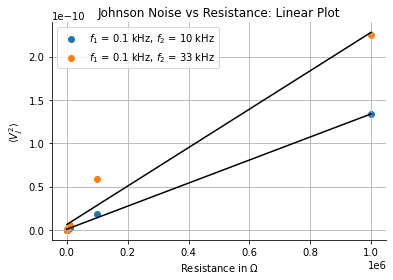

In [180]:
plt.scatter(resistance, johnson_noise, label = '$f_1$ = 0.1 kHz, $f_2$ = 10 kHz')
plt.scatter(resistance, johnson_noise_2, label = '$f_1$ = 0.1 kHz, $f_2$ = 33 kHz')

plt.plot(resistance, mresistance_1*resistance + bresistance_1, color = 'black')
plt.plot(resistance, mresistance_2*resistance + bresistance_2, color = 'black')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc = 0)

plt.xlabel("Resistance in $\Omega$")
plt.ylabel(r'$\langle V_J^2 \rangle $')
plt.grid()
plt.title("Johnson Noise vs Resistance: Linear Plot")
plt.savefig('Johnson_Noise_versus_resistance_1.pdf', bbox_inches='tight')

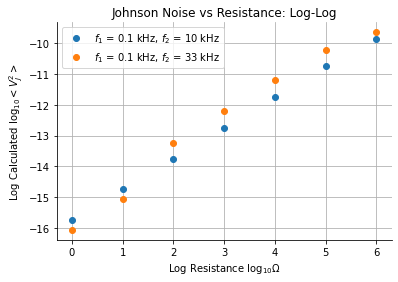

In [273]:
plt.errorbar(np.log10(resistance), np.log10(johnson_noise), fmt = 'o'\
                 , label = '$f_1$ = 0.1 kHz, $f_2$ = 10 kHz')
em, bee = np.polyfit(np.log10(resistance), np.log10(johnson_noise_2),1)
em2, bee2 = np.polyfit(np.log10(resistance), np.log10(johnson_noise),1)
plt.errorbar(np.log10(resistance), np.log10(johnson_noise_2), fmt = 'o', \
                  label = '$f_1$ = 0.1 kHz, $f_2$ = 33 kHz')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc = 0)

plt.xlabel("Log Resistance $\log_{10}\Omega$")
plt.ylabel("Log Calculated $\log_{10}< V_J ^2 >$")
plt.grid()
plt.title("Johnson Noise vs Resistance: Log-Log")
plt.savefig('Johnson_Noise_versus_resistance_both_LOG.pdf', bbox_inches='tight')

### Johnson Noise vs Resistance
1. Done for $f_1 = 0.1$ kHz and $f_2 = 33$ kHz for a gain of $500$. 

In [11]:
df_1Ohm = pd.read_csv(r'/Users/vinhtran/Downloads/Noise Measurements G3 Afternoon/Resistance Measurements/f1_0.1kHz_33kHz_1Ohm.csv', header = None)
df_10Ohm = pd.read_csv(r'/Users/vinhtran/Downloads/Noise Measurements G3 Afternoon/Resistance Measurements/f1_0.1kHz_33kHz_10Ohm_mV.csv', header = None)
df_100Ohm = pd.read_csv(r'/Users/vinhtran/Downloads/Noise Measurements G3 Afternoon/Resistance Measurements/f1_0.1kHz_33kHz_100_Ohm_mV.csv', header = None)
df_1kOhm = pd.read_csv(r'/Users/vinhtran/Downloads/Noise Measurements G3 Afternoon/Resistance Measurements/f1_0.1kHz_33kHz_1k_Ohm_mV.csv', header = None)
df_10kOhm = pd.read_csv(r'/Users/vinhtran/Downloads/Noise Measurements G3 Afternoon/Resistance Measurements/f1_0.1kHz_33kHz_10k_Ohm_mV.csv', header = None)
df_100kOhm = pd.read_csv(r'/Users/vinhtran/Downloads/Noise Measurements G3 Afternoon/Resistance Measurements/f1_0.1kHz_33kHz_100k_Ohm_V.csv', header = None)
df_1MOhm = pd.read_csv(r'/Users/vinhtran/Downloads/Noise Measurements G3 Afternoon/Resistance Measurements/f1_0.1kHz_33kHz_1M_Ohm_V.csv', header = None)

In [12]:
data_1Ohm = df_1Ohm.to_numpy()
data_10Ohm = df_10Ohm.to_numpy()
data_100Ohm = df_100Ohm.to_numpy()
data_1kOhm = df_1kOhm.to_numpy()
data_10kOhm = df_10kOhm.to_numpy()
data_100kOhm = df_100kOhm.to_numpy()
data_1MOhm = df_1MOhm.to_numpy()

In [13]:
voltage_1Ohm = np.mean(data_1Ohm)
voltage_10Ohm = np.mean(data_10Ohm)
voltage_100Ohm = np.mean(data_100Ohm)
voltage_1kOhm = np.mean(data_1kOhm)
voltage_10kOhm = np.mean(data_10kOhm)
voltage_100kOhm = np.mean(data_100kOhm)
voltage_1MOhm = np.mean(data_1MOhm)

voltages2 = np.array([voltage_1Ohm, voltage_10Ohm, voltage_100Ohm,\
                          voltage_1kOhm, voltage_10kOhm, voltage_100kOhm, voltage_1MOhm])
voltages2

array([0.01872236, 0.01872946, 0.01924389, 0.02420646, 0.07413657,
       0.54315179, 2.04504425])

In [163]:
# calculating V_out 
voltage_resistance_mean_vout_2 = V_johnson(voltages2, 500)

# extrapolate to calculate amp_noise
amplifier_noise_2 = amp_noise(resistance, voltage_resistance_mean_vout_2)

# substracting off amp_noise
johnson_noise_2 = voltage_resistance_mean_vout_2 - amplifier_noise_2

In [164]:
amplifier_noise_2

array(2.08017431e-12)

In [167]:
johnson_noise_2

array([8.76913580e-17, 8.76913580e-16, 5.80356914e-14, 6.09432025e-13,
       6.15722225e-12, 5.82700246e-11, 2.25146964e-10])

### Johnson Noise vs Equivalent Noise Bandwidth
1. Measuring here the $\langle V_J^2 \rangle$ as a function of equivalent noise bandwidth $\Delta f$.

In [101]:
resistance_bandwidth = np.array([1, 100*10**3])

In [235]:
# f1 = 10 Hz, f2 = 0.33 kHz, Resistor 1 Ohm - for amplifier noise purposes 
Delta_f1_1Ohm = np.array([-0.6650, -0.6541, -0.6570, -0.6663, -0.6653, -0.6392,\
                          -0.6539, -0.6555, -0.6590, -0.6474, -0.6326, -0.6427])/1000 #mV

# f1 = 10 Hz, f2 = 0.33 kHz, Resistor 100K Ohms
Delta_f1_100kOhm = np.array([4.2187, 4.4065, 4.2488, 4.2231, 4.1823,\
                                 4.3219, 4.7980, 4.5898, 4.1661, 4.4843])/1000 #mV

Delta_f1_1Ohm_mean = V_johnson(np.mean(Delta_f1_1Ohm), 500) # calculate mean for amplifier noise
Delta_f1_100kOhm_mean = V_johnson(np.mean(Delta_f1_100kOhm), 500) # calculate mean for 100K resistor


Delta_f1_100kOhm_PLOT = Delta_f1_100kOhm_mean - Delta_f1_1Ohm_mean # subtract off amplifier noise 

In [236]:
# f1 = 30 Hz, f2 = 1kHz, resistor 1 Ohm - amplifier noise
Delta_f2_1Ohm = np.array([-0.2417, -.2409, -0.2151, -0.2528, -0.1989,\
                              -0.1962, -0.2215, -0.2232, -0.2230, -0.1903])/1000 #mV

# f1 = 30 Hz, f2 = 1kHz, resistor 100K Ohm - amplifier noise
Delta_f2_100kOhm = np.array([15.8780, 15.9888, 16.0898, 16.0887, 15.3916,\
                                 15.8785, 15.4369, 15.4912, 15.6473, 15.5989])/1000 #mV

Delta_f2_1Ohm_mean = V_johnson(np.mean(Delta_f2_1Ohm),500)
Delta_f2_100kOhm_mean = V_johnson(np.mean(Delta_f2_100kOhm),500)

Delta_f2_100kOhm_PLOT = Delta_f2_100kOhm_mean - Delta_f2_1Ohm_mean

In [237]:
# f1 = 100 Hz, f2 = 3.3 kHz, 1 Ohm - amplifier noise
Delta_f3_1Ohm = np.array([1.1562, 1.1050, 1.1438, 1.0935, 1.1121,\
                              1.1083, 1.1302, 1.1183, 1.1091, 1.1710])/1000 #mV

# f1 = 100 Hz, f2 = 3.3 kHz, 100 kOhm
Delta_f3_100kOhm = np.array([54.3887, 54.7875, 54.5844, 54.0822, 54.2166, 54.8315\
                                 , 54.9866, 54.1602, 56.3720, 54.4033, 54.0825])/1000 #mV

Delta_f3_1Ohm_mean = V_johnson(np.mean(Delta_f3_1Ohm),500)
Delta_f3_100kOhm_mean = V_johnson(np.mean(Delta_f3_100kOhm),500)


Delta_f3_100kOhm_PLOT = Delta_f3_100kOhm_mean - Delta_f3_1Ohm_mean

In [238]:
# f1 = 300 Hz, f2 = 10 kHz, 1 Ohm - amplifier noise
Delta_f4_1Ohm = np.array([4.9796, 4.9537, 4.9306, 5.0400, 5.0934,\
                          5.0249, 5.0292, 5.0379, 4.9690, 4.9815])/1000 #mV

# f1 = 300 Hz, f2 = 10 kHz, 100 kOhm
Delta_f4_100kOhm = np.array([0.162694, 0.162576, 0.165044, 0.164578,\
                                 0.164917, 0.165559, 0.164751, 0.164432, 0.164021, 0.165278]) #V

Delta_f4_1Ohm_mean = V_johnson(np.mean(Delta_f4_1Ohm),500)
Delta_f4_100kOhm_mean = V_johnson(np.mean(Delta_f4_100kOhm),500)

Delta_f4_100kOhm_PLOT = Delta_f4_100kOhm_mean - Delta_f4_1Ohm_mean

In [239]:
# f1 = 1000 Hz, f2 = 33 kHz, 1 Ohm - amplifier noise
Delta_f5_1Ohm = np.array([18.9341, 18.8374, 18.5916, 18.7928, 18.6898,\
                              18.7990, 18.7728, 18.7199, 18.7872, 18.7762])/1000 #mV

# f1 = 1000 Hz, f2 = 33 kHz, 100 kOhms
Delta_f5_100kOhm = np.array([0.527957, 0.530889, 0.532465, 0.529698, 0.527447,\
                             0.527589, 0.528438, 0.529136, 0.529747, 0.528859]) #V

Delta_f5_1Ohm_mean = V_johnson(np.mean(Delta_f5_1Ohm),500)
Delta_f5_100kOhm_mean = V_johnson(np.mean(Delta_f5_100kOhm),500)

Delta_f5_100kOhm_PLOT = Delta_f5_100kOhm_mean - Delta_f5_1Ohm_mean

In [240]:
# f1 = 3000 Hz, f2 = 100 kHz, 1 Ohm - amplifier noise
Delta_f6_1Ohm = np.array([59.5149, 59.3589, 59.2497, 59.5095,\
                          59.4760, 59.4581, 59.4974, 59.6094, 59.5189, 59.2918])/1000 #V

# f1 = 3000 Hz, f2 = 100 kHz, 100 kOhms
Delta_f6_100kOhm = np.array([1.32735, 1.32775, 1.33113, 1.32769,\
                             1.32967, 1.33055, 1.33258, 1.32968, 1.33532, 1.33775, 1.33450]) #V

Delta_f6_1Ohm_mean = V_johnson(np.mean(Delta_f6_1Ohm),500)
Delta_f6_100kOhm_mean = V_johnson(np.mean(Delta_f6_100kOhm),500)

Delta_f6_100kOhm_PLOT = Delta_f6_100kOhm_mean - Delta_f6_1Ohm_mean

In [242]:
bandwidth = np.array([355, 1077, 3554, 10774, 35543, 107740])

f2 = np.array([0.33, 1.0, 3.3, 10, 33, 100])*1000 #Hz
f1 = np.array([10, 30, 100, 300, 1000, 3000]) #Hz

frequency_diff = np.abs(f2-f1)

bandwidth_voltages = np.array([Delta_f1_100kOhm_PLOT, Delta_f2_100kOhm_PLOT, Delta_f3_100kOhm_PLOT, Delta_f4_100kOhm_PLOT,\
                        Delta_f5_100kOhm_PLOT, Delta_f6_100kOhm_PLOT])

### Johnson Noise vs Bandwidth Linear Plot

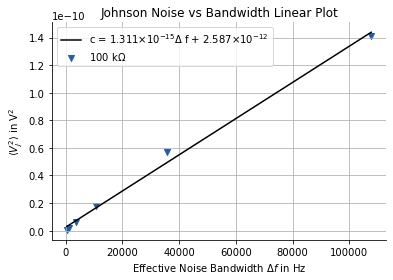

In [257]:
plt.scatter(bandwidth, bandwidth_voltages, label = '100 k$\Omega$', marker = "v", color = '#225ea8')
plt.plot(bandwidth, mlinear*bandwidth + blinear, label = r'c = 1.311$\times 10^{-15}$$\Delta$ f + 2.587$\times 10^{-12}$ ', color = 'black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Effective Noise Bandwidth $\Delta f$ in Hz")
plt.ylabel(r"$\langle  V_J ^2 \rangle$ in V$^2$")
plt.legend(loc=0)
plt.grid()
plt.title("Johnson Noise vs Bandwidth Linear Plot")
plt.savefig('Johnson_Noise_versus_bandwidth_LINEAR_PLOT.pdf', bbox_inches='tight')

### Linear Regression

In [252]:
mlinear, blinear = np.polyfit(bandwidth, bandwidth_voltages,1)
blinear

2.587164391315185e-12

In [225]:
m1, b1 = np.polyfit(np.log10(bandwidth), np.log10(bandwidth_voltages), 1)
b1

-24.663441410502873

In [134]:
### Slope Calculator
kB = 1.381*10**(-23)
T = 300
R = 100*10**3
4*kB*T*R

1.6571999999999998e-15

### Johnson Noise vs Bandwidth Log Log

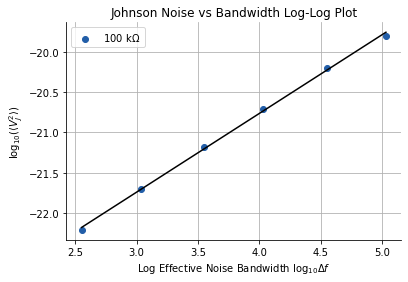

In [186]:
plt.scatter(np.log10(bandwidth), np.log10(bandwidth_voltages), label = '100 k$\Omega$', color = '#225ea8')
plt.plot(np.log10(bandwidth), m1*np.log10(bandwidth) + b1, color = 'black')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Log Effective Noise Bandwidth $\log_{10} \Delta f$")
plt.ylabel(r"$\log_{10}(\langle  V_J ^2 \rangle)$")
plt.legend(loc=0)
plt.grid()
plt.title("Johnson Noise vs Bandwidth Log-Log Plot")
plt.savefig('Johnson_Noise_versus_bandwidth_LOG.pdf', bbox_inches='tight')

#### Johnson Noise vs Difference in Frequency (Log-Log)

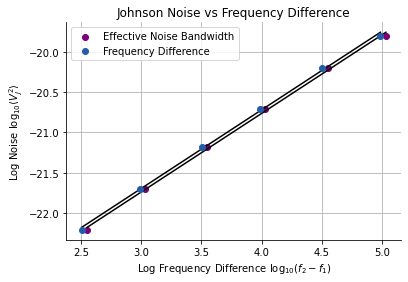

In [193]:
plt.errorbar(np.log10(frequency_diff), np.log10(bandwidth_voltages), fmt = 'o', label = 'Frequency Difference', color = '#225ea8')

m, b = np.polyfit(np.log10(frequency_diff), np.log10(voltages), 1)
plt.plot(np.log10(frequency_diff), m*np.log10(frequency_diff) + b, color = 'black')

plt.scatter(np.log10(bandwidth), np.log10(bandwidth_voltages), label = 'Effective Noise Bandwidth', color = '#7a0177')
plt.plot(np.log10(bandwidth), m1*np.log10(bandwidth) + b1, color = 'black')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 0)
plt.xlabel("Log Frequency Difference $\log_{10}(f_2 - f_1)$")
plt.ylabel(r"Log Noise $\log_{10}\langle V_J ^2 \rangle$")
plt.grid()
plt.title("Johnson Noise vs Frequency Difference")
plt.savefig('Johnson_Noise_versus_bandwidth_frequency.pdf', bbox_inches='tight')

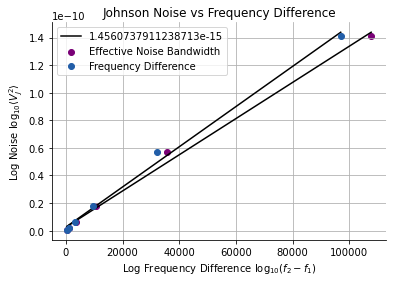

In [260]:
plt.errorbar(frequency_diff, bandwidth_voltages, fmt = 'o', label = 'Frequency Difference', color = '#225ea8')
m, b = np.polyfit(frequency_diff, bandwidth_voltages, 1)
plt.plot(frequency_diff, m*frequency_diff + b, color = 'black', label = m)

plt.scatter(bandwidth, bandwidth_voltages, label = 'Effective Noise Bandwidth', color = '#7a0177')
m1, b1 = np.polyfit(bandwidth, bandwidth_voltages, 1)
plt.plot(bandwidth, m1*bandwidth + b1, color = 'black')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 0)
plt.xlabel("Log Frequency Difference $\log_{10}(f_2 - f_1)$")
plt.ylabel(r"Log Noise $\log_{10}\langle V_J ^2 \rangle$")
plt.grid()
plt.title("Johnson Noise vs Frequency Difference")
plt.savefig('Johnson_Noise_versus_bandwidth_frequency.pdf', bbox_inches='tight')

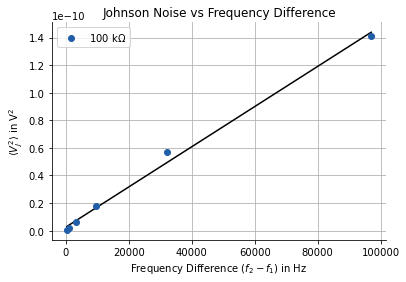

In [267]:
plt.errorbar(frequency_diff, bandwidth_voltages, fmt = 'o', label = '100 k$\Omega$', color = '#225ea8')
m, b = np.polyfit(frequency_diff, bandwidth_voltages, 1)
plt.plot(frequency_diff, m*frequency_diff + b, color = 'black')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 0)
plt.xlabel("Frequency Difference $(f_2 - f_1)$ in Hz")
plt.ylabel(r"$\langle V_J ^2 \rangle$ in V$^2$")
plt.grid()
plt.title("Johnson Noise vs Frequency Difference")
plt.savefig('Johnson_Noise_versus_bandwidth_frequency_LINEAR.pdf', bbox_inches='tight')

### Johnson Noise vs Bandwidth, and Difference in Frequency

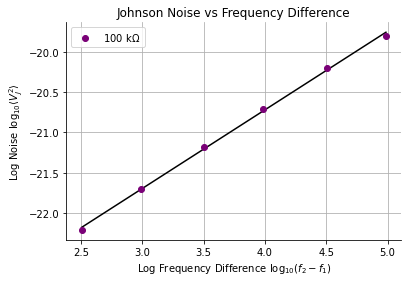

In [196]:
plt.errorbar(np.log10(frequency_diff), np.log10(bandwidth_voltages), label = '100 k$\Omega$' ,fmt = 'o', color = '#7a0177')

m, b = np.polyfit(np.log10(frequency_diff), np.log10(voltages), 1)
plt.plot(np.log10(frequency_diff), m*np.log10(frequency_diff) + b, color = 'black')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc = 0)

plt.xlabel("Log Frequency Difference $\log_{10}(f_2 - f_1)$")
plt.ylabel(r"Log Noise $\log_{10}\langle V_J ^2 \rangle$")
plt.grid()
plt.title("Johnson Noise vs Frequency Difference")
plt.savefig('Johnson_Noise_versus_F_Diff.pdf', bbox_inches='tight')

#### Johnson Noise vs F1 (Log-Log)

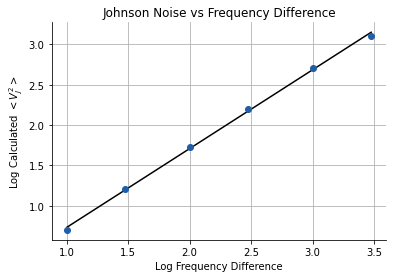

In [98]:
plt.errorbar(np.log10(f1), np.log10(voltages), fmt = 'o', color = '#225ea8')

m, b = np.polyfit(np.log10(f1), np.log10(voltages), 1)
plt.plot(np.log10(f1), m*np.log10(f1) + b, color = 'black')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Log Frequency Difference")
plt.ylabel("Log Calculated $< V_J ^2 >$")
plt.grid()
plt.title("Johnson Noise vs Frequency Difference")
plt.savefig('Johnson_Noise_versus_F_Diff', bbox_inches='tight')

#### Johnson Noise vs F2 (Log-Log)

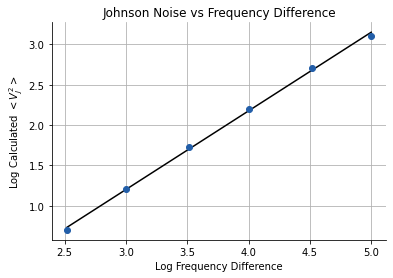

In [99]:
plt.errorbar(np.log10(f2), np.log10(voltages), fmt = 'o', color = '#225ea8')

m, b = np.polyfit(np.log10(f2), np.log10(voltages), 1)
plt.plot(np.log10(f2), m*np.log10(f2) + b, color = 'black')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Log Frequency Difference")
plt.ylabel("Log Calculated $< V_J ^2 >$")
plt.grid()
plt.title("Johnson Noise vs Frequency Difference")
plt.savefig('Johnson_Noise_versus_F_Diff', bbox_inches='tight')

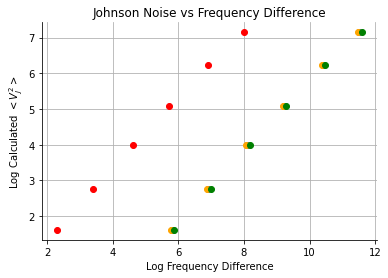

In [106]:
plt.errorbar(np.log(f2), np.log(voltages), fmt = 'o', color = '#225ea8')
plt.errorbar(np.log(f1), np.log(voltages), fmt = 'o', color = 'red')
plt.errorbar(np.log(frequency_diff), np.log(voltages), fmt = 'o', color = 'orange')
plt.errorbar(np.log(bandwidth), np.log(voltages), fmt = 'o', color = 'green')

#m, b = np.polyfit(np.log10(f2), np.log10(voltages), 1)
#plt.plot(np.log10(f2), m*np.log10(f2) + b, color = 'black')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Log Frequency Difference")
plt.ylabel("Log Calculated $< V_J ^2 >$")
plt.grid()
plt.title("Johnson Noise vs Frequency Difference")
plt.savefig('Johnson_Noise_versus_F_Diff', bbox_inches='tight')

### Noise Density

#### Exercise 2.1

In [37]:
ex_1 = pd.read_csv(r'/Users/vinhtran/Downloads/Exercise_2_1.csv', header = None)

In [38]:
# convert data to numpy array
ex_1_data = ex_1.to_numpy()

# extract columns into single arrays
rms_input = ex_1_data[:,0]*1000
rms_output = ex_1_data[:,1]
frequency = ex_1_data[:,2]

# calculate Gain
gain = rms_output/rms_input

In [305]:
def butterworth(f, f1, f2):
    return (f/f1)**2/np.sqrt(1+(f/f1)**4)/np.sqrt(1+(f/f2)**4)
def butterworth_squared(f, f1, f2):
    return butterworth(f,f1,f2)**2

In [277]:
frequency

array([  0.1 ,   0.15,   0.2 ,   0.25,   0.3 ,   0.35,   0.4 ,   0.45,
         0.5 ,   0.55,   0.6 ,   0.65,   0.7 ,   0.75,   0.8 ,   0.9 ,
         1.  ,   1.1 ,   1.2 ,   1.3 ,   1.4 ,   1.5 ,   2.  ,   5.  ,
        10.  ,  15.  ,  20.  ,  25.  ,  30.  ,  35.  ,  40.  ,  45.  ,
        50.  ,  55.  ,  60.  ,  65.  ,  70.  ,  75.  ,  80.  ,  85.  ,
        90.  ,  95.  , 100.  ])

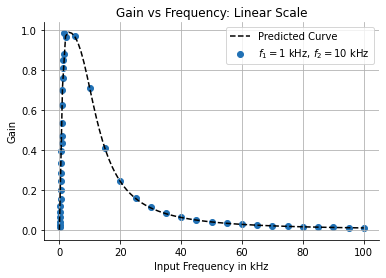

In [320]:
plt.scatter(frequency, gain, label = '$f_1 = 1$ kHz, $f_2 = 10$ kHz', color = '#2171b5')
X = np.linspace(0,100,100)
plt.plot(X, butterworth2(X,1,10), linestyle='dashed', color = 'black', label = 'Predicted Curve')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Input Frequency in kHz")
plt.ylabel("Gain")
plt.legend(loc = 0)

plt.grid()
plt.title("Gain vs Frequency: Linear Scale")
plt.savefig('Gain_vs_frequency_linear.pdf', bbox_inches='tight')

In [317]:
integrate.quad(butterworth_squared, 0.1, 100, args = (1,10))

(9.994151169132378, 3.92292189459794e-08)

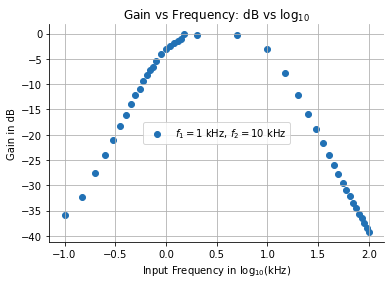

In [207]:
plt.scatter(np.log10(frequency), 20*np.log10(gain), label = '$f_1 = 1$ kHz, $f_2 = 10$ kHz', color = '#2171b5')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Input Frequency in $\log_{10}$(kHz)")
plt.ylabel("Gain in dB")
plt.legend(loc=10)
plt.grid()
plt.title("Gain vs Frequency: dB vs $\log_{10}$")
plt.savefig('Gain_vs_frequency_log_dB.pdf', bbox_inches='tight')

### Gain^2 Log Scale

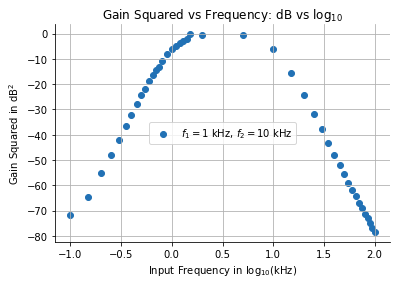

In [220]:
plt.scatter(np.log10(frequency), 20*np.log10(gain**2), label = '$f_1 = 1$ kHz, $f_2 = 10$ kHz', color = '#2171b5')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Input Frequency in $\log_{10}$(kHz)")
plt.ylabel("Gain Squared in dB$^2$")
plt.legend(loc=10)
plt.grid()
plt.title("Gain Squared vs Frequency: dB vs $\log_{10}$")
plt.savefig('Gain_vs_frequency_log_dB_squared.pdf', bbox_inches='tight')

### Exercise 2.2

In [59]:
ex_2 = pd.read_csv(r'/Users/vinhtran/Downloads/Exercise2_2.csv', header = None)

# convert data to numpy array
ex_2_data = ex_2.to_numpy()

# extract columns into single arrays
rms_input_2 = ex_2_data[:,0]
rms_output_2 = ex_2_data[:,1]
frequency_2 = ex_2_data[:,2]

# calculate Gain
gain_2 = rms_output_2/rms_input_2

In [312]:
def butterworth_highpass(f,f1):
    return (f/f1)**2/np.sqrt(1+(f/f1)**4)

def butterworth_lowpass(f,f1):
    return 1/np.sqrt(1+(f/f1)**4)

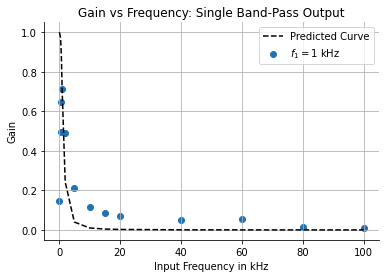

In [313]:
plt.scatter(frequency_2, gain_2, label = '$f_1 = 1$ kHz', color = '#2171b5')
plt.plot(frequency_2, butterworth_lowpass(frequency_2,1),\
             color = 'black', linestyle='dashed', label = 'Predicted Curve')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Input Frequency in kHz")
plt.ylabel("Gain")
plt.legend(loc = 0)
plt.grid()
plt.title("Gain vs Frequency: Single Band-Pass Output")
plt.savefig('Gain_vs_frequency_one_filter.pdf', bbox_inches='tight')

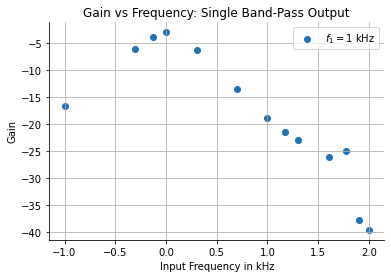

In [268]:
plt.scatter(np.log10(frequency_2), 20*np.log10(gain_2), label = '$f_1 = 1$ kHz', color = '#2171b5')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Input Frequency in kHz")
plt.ylabel("Gain")
plt.legend(loc = 0)
plt.grid()
plt.title("Gain vs Frequency: Single Band-Pass Output")
plt.savefig('Gain_vs_frequency_one_filter.pdf', bbox_inches='tight')

### Exercise 2.3

#### Below, we use $f_1 = 1$ kHz and $f_2 = 10$ kHz and plot $G^2(f)$ for $f \in [0, 100]$ kHz, the data from exercise 2.1, using a linear scale

<font color='red'>
1. To do still: repeat this measurement but take more measurements in between 0.1 and 1 kHz because that's pretty important it seems.
    
2. Repeat this for different combinations of f1, f2
</font>

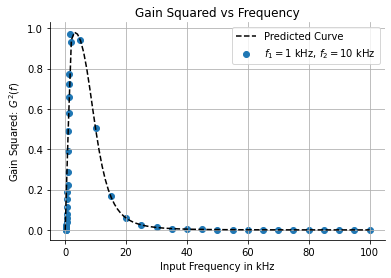

In [321]:
plt.scatter(frequency, gain**2, label = '$f_1 = 1$ kHz, $f_2 = 10$ kHz')
plt.plot(X, butterworth_squared(X, 1, 10),\
             color = 'black', linestyle='dashed', label = 'Predicted Curve')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 0)

plt.xlabel("Input Frequency in kHz")
plt.ylabel("Gain Squared: $G^2(f)$")
plt.grid()
plt.title("Gain Squared vs Frequency")
plt.savefig('Gain_squared_vs_frequency_2.pdf', bbox_inches='tight')

### Calculating the Area underneath the curve of $G^2(f)$. 
1. To do this, first, we interpolate between the data points to get a function that we can integrate. 
2. Then we integrate the function by calling quad. 

In [184]:
func = interpolate.CubicSpline(frequency, gain**2)

In [195]:
Area_under_curve = integrate.quad(func, 0, 100)[0]
Area_under_curve

9.990401829503535

In [81]:
integrate.trapezoid(gain**2, frequency)

10.074796003010826

### Wednesday Dec 15: Early Morning 2AM Coding Session


In [335]:
def diff(val_1, val_2):
    return np.abs(val_1 - val_2)/np.mean([val_1,val_2])*100

In [343]:
diff(5.552,3.263)

51.93420306296086

In [341]:
diff(1,2)

66.66666666666666

In [348]:
#optimize.curve_fit(butterworth, frequency, gain)
popt, etc = optimize.curve_fit(butterworth, frequency, gain)
popt

array([ 1.00519196, 10.07167026])

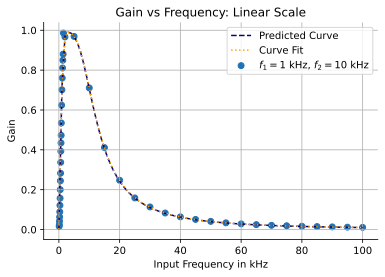

In [358]:
plt.scatter(frequency, gain, label = '$f_1 = 1$ kHz, $f_2 = 10$ kHz', color = '#2171b5')
X = np.linspace(0,100,100)
plt.plot(X, butterworth2(X,1,10), linestyle='dashed', color = 'navy', label = 'Predicted Curve')
plt.plot(X, butterworth(X,popt[0],popt[1]), linestyle = 'dotted', color = 'orange', label = 'Curve Fit')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel("Input Frequency in kHz")
plt.ylabel("Gain")
plt.legend(loc = 0)

plt.grid()
plt.title("Gain vs Frequency: Linear Scale")
plt.savefig('Gain_vs_frequency_linear_w_fit.pdf', bbox_inches='tight')